# Data Discovery: Exploration and Transformation of <i>Raw Data</i>

This notebook orchestrates the preprocessing of raw data. It reads the raw data, explores it, applies transformations, and generates the processed dataset.


# 1. Environment setup

## 1.1. Import libraries

In [1]:
import sys
from pathlib import Path

project_root = Path().resolve().parent
sys.path.append(str(project_root))

In [ ]:
import numpy as np
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

from src.preprocessing.preprocessing import data_preparation
from src.preprocessing.helpers.data_helpers import get_raw_dataset, split_dataset
from src.config.config_file import RAW_DATA_DIR, SPLIT_DATA_DIR
from src.utils.plots import show_images_per_class, bar_plot

# 2. Load raw data

In [3]:
dataset = get_raw_dataset(RAW_DATA_DIR, transform=None)

# 3. Explore data

In [4]:
print(f"Number of classes: {len(dataset.classes)}")
print("Class names:", dataset.classes)

Number of classes: 12
Class names: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']


In [5]:
class_counts = Counter(dataset.targets)
for idx, class_name in enumerate(dataset.classes):
    print(f"{class_name}: {class_counts[idx]} images => {class_counts[idx] / len(dataset) * 100:.2f}%")

battery: 945 images => 6.09%
biological: 985 images => 6.35%
brown-glass: 607 images => 3.91%
cardboard: 891 images => 5.74%
clothes: 5325 images => 34.32%
green-glass: 629 images => 4.05%
metal: 769 images => 4.96%
paper: 1050 images => 6.77%
plastic: 865 images => 5.58%
shoes: 1977 images => 12.74%
trash: 697 images => 4.49%
white-glass: 775 images => 5.00%


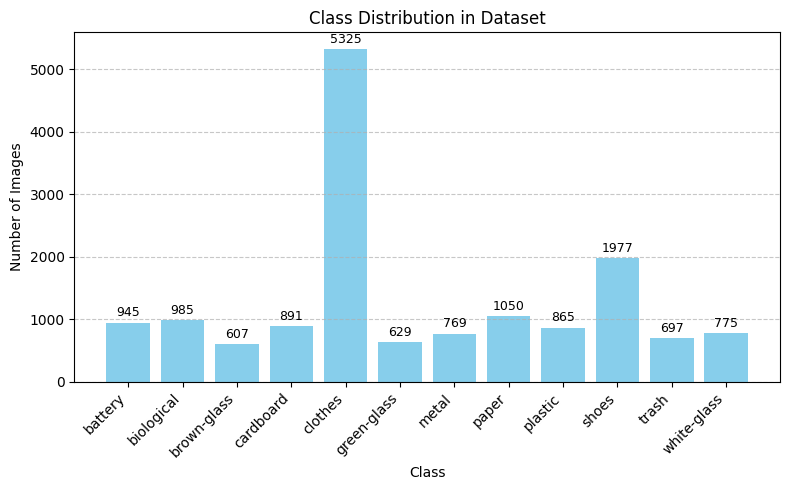

In [6]:
class_counts = Counter(dataset.targets)
labels = [dataset.classes[i] for i in range(len(dataset.classes))]
values = [class_counts[i] for i in range(len(dataset.classes))]

bar_plot(
    labels,
    values,
    title="Class Distribution in Dataset",
    xlabel="Class",
    ylabel="Number of Images",
    figsize=(8, 5)
)

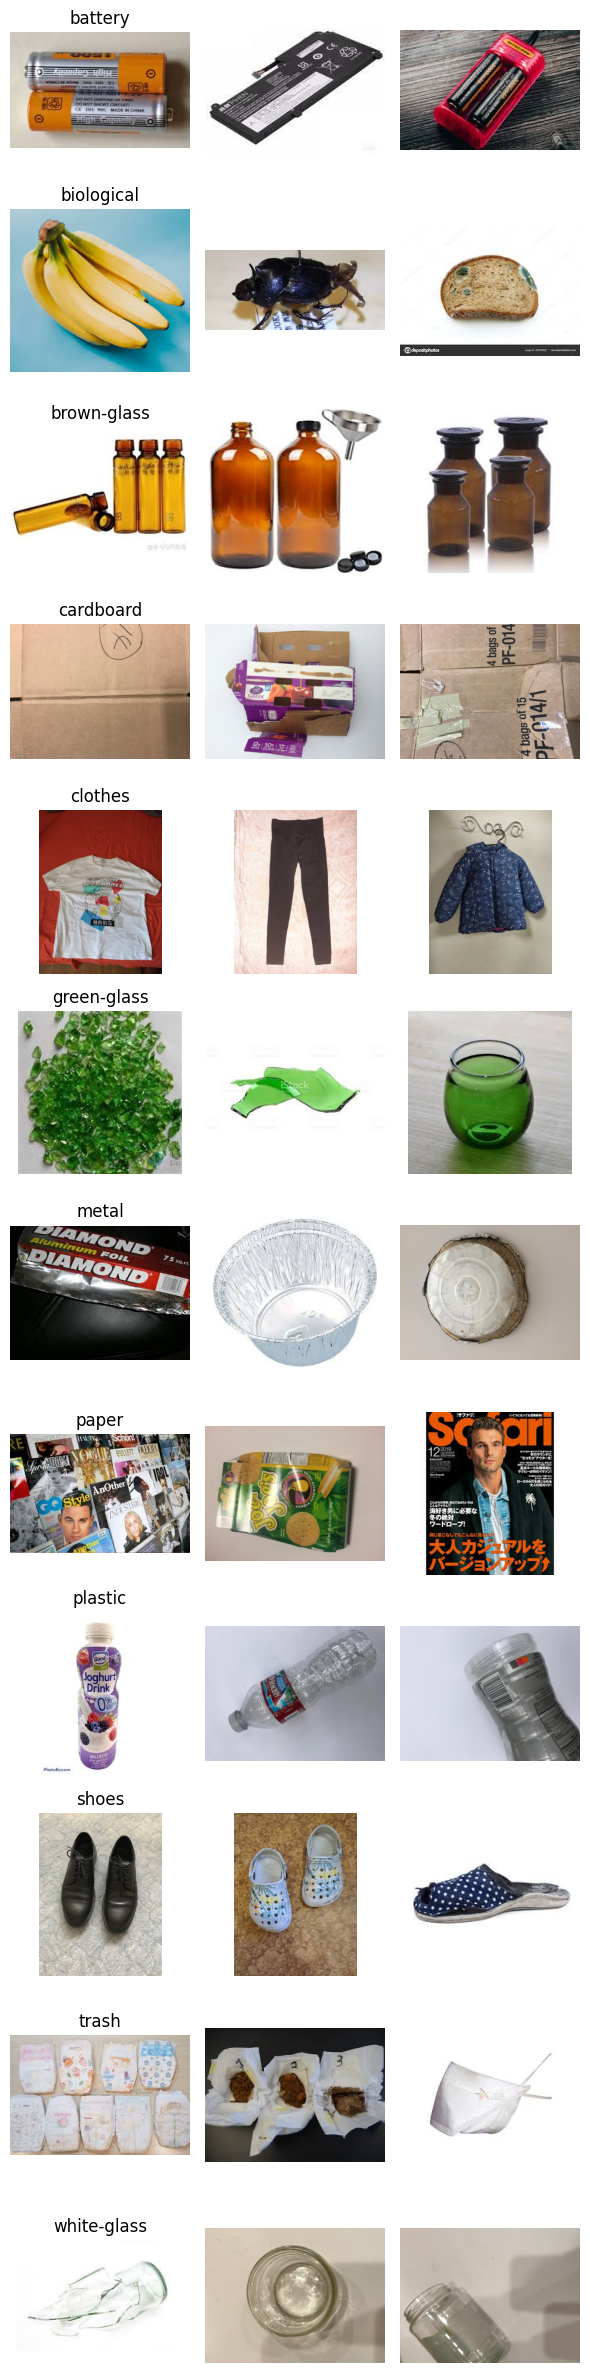

In [7]:
show_images_per_class(dataset, dataset.classes)

In [8]:
sizes = []
for path, _ in dataset.samples:
    with Image.open(path) as img:
        sizes.append(img.size)

widths, heights = zip(*sizes)
print(f"Average size: {np.mean(widths):.1f}x{np.mean(heights):.1f}")
print(f"Min size: {min(widths)}x{min(heights)}")
print(f"Max size: {max(widths)}x{max(heights)}")


Average size: 349.8x351.7
Min size: 51x100
Max size: 888x936


In [9]:
modes = []
for path, _ in dataset.samples:
    with Image.open(path) as img:
        modes.append(img.mode)
print("Image modes:", Counter(modes))

Image modes: Counter({'RGB': 15481, 'P': 34})


### Conclusions of data exploration

- **Number of classes:** 12  
  The dataset contains 12 distinct waste categories, making it suitable for a multi-class classification task.

- **Class imbalance:**  
  There is a strong imbalance between classes:  
  - The `clothes` (5325 images) and `shoes` (1977) categories dominate the dataset accounting for **~47%** of the total.
  - The remaining classes are more balanced among themselves, although some like `brown-glass`, `trash`, and `green-glass` have fewer than **5%** of the images.

  ⚠️ *This imbalance could negatively impact model performance.*  
  **Recommended actions:**  
  - Use data augmentation on minority classes  
  - Apply oversampling or undersampling  
  - Consider using class weights during training

- **Image sizes:**  
  - **Average size:** ~350×352 pixels  
  - **Smallest image:** 51×100 pixels  
  - **Largest image:** 888×936 pixels  

  📏 *Standardizing input size is necessary.*  
  **Recommended action:** Resize all images to a consistent resolution (e.g., 224×224) during preprocessing.

- **Image modes:**  
  - Most images are in **RGB** format  
  - **34 images** are in **P (palettized)** mode  

  🎨 *To avoid mode mismatch during training:*  
  **Recommended action:** Convert all images to RGB:
  ```python
  image = image.convert("RGB")


# 4. Define transformations

Before training, we apply a structured preprocessing pipeline that includes **dataset splitting**, **transformations**, and **imbalance handling**:

### 🗂 Dataset Splitting

- The original dataset is split into three subsets:
  - **Train**: 80%
  - **Validation**: 10%
  - **Test**: 10%
- The split is **stratified**, ensuring each class maintains its original proportion across subsets.
- If the split already exists in `data/split/`, it is **reused** to avoid unnecessary recomputation.

### 🎨 Image Transformations

- All images are **converted to RGB** (important since some were in `P` mode).
- They are **resized** to a fixed size (e.g., 128x128) to standardize input shape.
- **Normalization** is applied using ImageNet statistics:
  - `mean = [0.485, 0.456, 0.406]`
  - `std = [0.229, 0.224, 0.225]`
- Only the **training set** includes data augmentation to improve generalization:
  - E.g., random horizontal flips or rotations.

### ⚖️ Class Imbalance Handling

- The training set suffers from significant **class imbalance**, especially overrepresented classes like `clothes` and `shoes`.
- To address this, we use a **weighted random sampler** that increases the likelihood of selecting underrepresented classes during training.
- This ensures **more balanced batches**, improving model learning.


In [10]:
split_dataset(input_dir=RAW_DATA_DIR, output_dir=SPLIT_DATA_DIR, val_pct=0.1, test_pct=0.1)

2025-07-19 19:3723 | waste-classification | INFO | data_helpers.py | @function split_dataset | line 63 | Splitting dataset...
2025-07-19 19:3845 | waste-classification | INFO | data_helpers.py | @function split_dataset | line 96 | Dataset successfully split into train/val/test.


2025-07-19 20:0559 | waste-classification | INFO | preprocessing.py | @function data_preparation | line 37 | Starting data preparation pipeline...
2025-07-19 20:0559 | waste-classification | DEBUG | preprocessing.py | @function data_preparation | line 38 | Input directory: C:\Users\carlo\Desktop\master\deeplearning_project\data\raw
2025-07-19 20:0559 | waste-classification | DEBUG | preprocessing.py | @function data_preparation | line 39 | Output directory (split): C:\Users\carlo\Desktop\master\deeplearning_project\data\split
2025-07-19 20:0559 | waste-classification | DEBUG | preprocessing.py | @function data_preparation | line 40 | Batch size: 8
2025-07-19 20:0559 | waste-classification | INFO | data_helpers.py | @function split_dataset | line 60 | Found existing split in C:\Users\carlo\Desktop\master\deeplearning_project\data\split, skipping split.
2025-07-19 20:0559 | waste-classification | INFO | preprocessing.py | @function data_preparation | line 46 | Loading train data from C:\

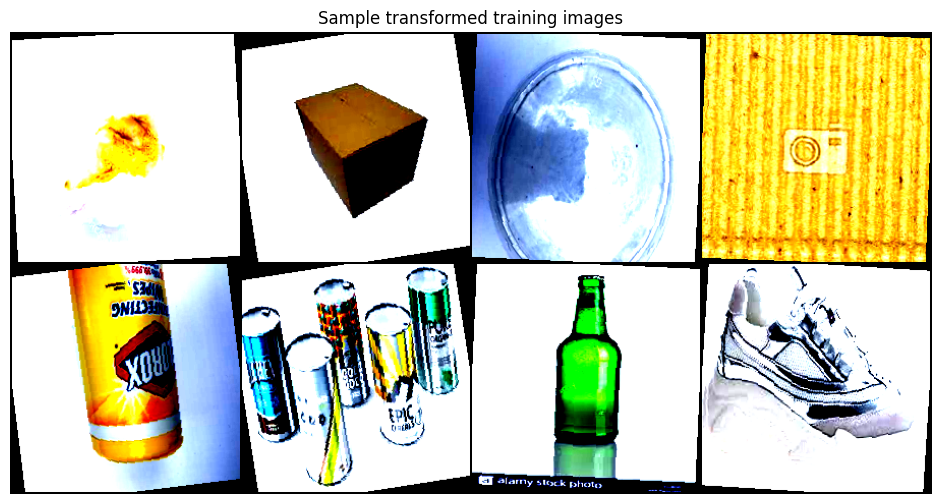

In [ ]:
dataloaders = data_preparation(RAW_DATA_DIR, SPLIT_DATA_DIR, batch_size=8)

# Visualize one batch
images, labels = next(iter(dataloaders['train']))

# Show some transformed images
plt.figure(figsize=(12, 6))
grid = torchvision.utils.make_grid(images, nrow=4)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title("Sample transformed training images")
plt.show()